# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import ipynb.fs     #Para importar desde ipynb
import matplotlib.pyplot as plt

Num GPUs Available:  1


# Preparacion de los datos

In [2]:
from .defs.preparacion_datos import unpickle, tryDataset

(60000, 28, 28, 1)


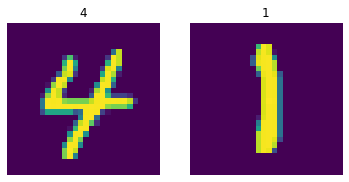

(10000, 28, 28, 1)


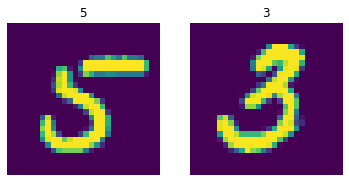

In [3]:
X_train = unpickle("Input\MNIST-train")
X_test = unpickle("Input\MNIST-test")
tryDataset(X_train)
tryDataset(X_test)

# Arquitectura del ``Autoencoder``

In [4]:
from .defs.arquitectura import *

# Entrenamiento

## Persistencia

In [5]:
_raiz = "Resultados/MNISTpruebasAAE"
_nombre = "MNISTpAAE"

Creamos las carpetas para almacenar el output

In [6]:
def mkfolders(ruta, verbose=False):
    try:
        os.makedirs(ruta)
    except OSError:
        if verbose: print("Carpeta %s ya existe" % (ruta))
    

In [7]:
mkfolders(_raiz, True)

Carpeta Resultados/MNISTpruebasAAE ya existe


## Funciones de muestreo

In [8]:
def sample_imgs(dataset, model, epoch, nclases, sample_size=5, save_imgs=True, show=False, ruta=_raiz, nombre="", title=""):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset["data"].shape[0], sample_size)
    set={k:v[ids] for k,v in dataset.items()}
    sample = set["data"]
    if nclases > 1:
        model_input=set
        model_input["labels"]=onehotify(model_input["labels"], nclases)
    else:
        model_input=sample
    # Intentamos regenerar las imagenes
    gen_img = model.predict(model_input)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    if title!="":
        f.suptitle(title+"_"+nombre, fontsize=12)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        ruta+="/Output/Regeneracion"
        mkfolders(ruta)
        savefile= ruta+"/"+nombre+"generationCIFAR10_e%d.jpg" % (epoch)
        f.savefig(savefile)
    if show:
        plt.show()
    plt.close()
    

In [9]:
def generate_samples(dim_latente, decoder, epoch, ruta=_raiz, nombre=_nombre, output=True, show=False):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    if output:
        ruta+="/Output/Progreso"
        mkfolders(ruta)
    fig.savefig(ruta+"\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    if show:
        print("Imagenes generadas desde el espacio latente:")
        plt.show()
    plt.close()

    

In [10]:
from IPython.display import Image
from IPython.display import display
def show_prevResults(ruta, nombre=_nombre, epochs=5000):
    
    x = Image(filename=ruta+'\\Output/Progreso'+"\\"+nombre+"progresscifar10_e%d.png" % (epochs-1))
    print("Imagenes generadas desde el espacio latente:")
    display(x)

    x = Image(filename=ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    print("Historia del entrenamiento:")
    display(x)

    x = Image(filename=ruta+"/Output/Regeneracion/TRAINSETgenerationCIFAR10_e%d.jpg" % (epochs))
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):") 
    display(x) 
     
    x = Image(filename=ruta+"/Output/Regeneracion/TESTSETgenerationCIFAR10_e%d.jpg" % (epochs))         
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    display(x)

    #n = np.random.randint(0, 10)
    #x = Image(filename=ruta+"/Output/Latente/GenFromLatentTRAINSET label %d.jpg" % (n))         
    #print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TrainSet):")
    #display(x)
    
    #x = Image(filename=ruta+"/Output/Latente/GenFromLatentTESTSET label %d.jpg" % (n))         
    #print("Imagenes generadas desde el punto medio entre coordenadas latentes de dos imagenes (TestSet):")
    #display(x)
    

In [11]:
def exploraLatente(encoder, decoder, groupPath, ruta=_raiz, nombre=_nombre):
    groups = unpickle(groupPath)
    ruta+="/Output/Latente"
    mkfolders(ruta)
    for key in groups.keys():
        imgs = groups[key]
        latent = []
        size = len(imgs)
        # Obtencion de coordenadas en espacio latente
        #for i in range(size):
        pred = encoder.predict(imgs)
        latent = pred
            #latent.append(pred)
        # Obtenemos la coordenada intermedia
        latent = tf.math.divide(tf.math.add_n(latent),size)
        latent = np.array([latent])
        #Generamos la imagen de esa coordenada
        generated = decoder.predict(latent)

        f, axxs = plt.subplots(1,size+1)
        f.suptitle("Latent aproximation for class "+str(key)+" from " + groupPath, fontsize=12)
        for j in range(size):
            axxs[j].imshow(imgs[j])
            axxs[j].axis("off")
            axxs[j].set_title("Real")
        axxs[size].imshow(generated[0])
        axxs[size].axis("off")
        axxs[size].set_title("Generated")
        plt.show()
        plt.close()
        
        f.savefig(ruta+"\\"+nombre+" label %d.jpg" % (key))

In [12]:
def plotlatent2D(encoder, dataset, ruta=_raiz, nombre=_nombre):
    ruta+="/Output/Latente"
    mkfolders(ruta)
    points = encoder.predict(dataset["data"])

    x = np.array(list(x for (x,_) in points))
    y = np.array(list(y for (_,y) in points))
    colors = dataset["labels"]

    plt.scatter(x, y, c=colors, cmap='hsv')

    plt.colorbar()
    fig = plt.gcf()
    plt.show()
    fig.savefig(ruta+"\\"+nombre+"_space.jpg")
    plt.close()

## Generacion de ejemplos (positivos y negativos)

In [13]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [14]:
true_sampler(3, 2)

array([[ 0.84431839,  1.47966988,  0.34620376],
       [ 1.67290436,  0.4065989 , -0.73523081]])

In [15]:
def onehotify(labels, nclases):
    onehotlabels = []
    for label in labels:
        thisLabel = np.zeros(nclases)
        thisLabel[label]=1
        onehotlabels.append(thisLabel)
    return np.array(onehotlabels)

In [16]:
def true_sampler_clases(dim_latente, batch_size, nclases):
    samples = []
    sigma = 1/nclases
    clases = np.random.randint(0, nclases, batch_size)
    clases1hot= onehotify(clases, nclases)
    for clase in clases:        
        mu = clase*sigma+(0.5*sigma)
        s = np.random.normal(loc = mu, scale=sigma, size=dim_latente)
        samples.append(s)
    return np.array(samples), clases1hot

In [17]:
true_sampler_clases(2,2,10)

(array([[0.19016567, 0.36953329],
        [0.64425875, 0.81296292]]),
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]))

In [18]:
def fake_sampler(imgs, encoder):
    latent_fake = encoder.predict(imgs["data"])
    return latent_fake

In [19]:
def fake_class_sampler(imgs, encoder, nclases):
    latent_fake = encoder.predict(imgs["data"])
    labels = onehotify(imgs["labels"], nclases)
    return latent_fake, labels

## Grafica de progreso

In [20]:
def plot_history(history, ruta=_raiz, nombre=_nombre, title=""):
    disc_loss = history[0]
    disc_acc  = history[1]
    aac_loss1 = history[2]
    aac_loss2 = history[3]

    fig, axxs = plt.subplots(1,3)
    if title != "":
        fig.suptitle(title, fontsize=16)

    fig.set_figwidth(24)
    fig.set_figheight(6)

    axxs[0].set_title("Discriminator")
    axxs[1].set_title("Discriminator")
    axxs[2].set_title("AdversarialAutoencoder")

    axxs[0].set_xlabel("Epoch")
    axxs[1].set_xlabel("Epoch")
    axxs[2].set_xlabel("Epoch")

    axxs[0].plot(disc_loss, label = "Loss")
    axxs[1].plot(disc_acc, label = "Accuracy")

    axxs[2].plot(aac_loss1, label = "Loss_decoder")
    axxs[2].plot(aac_loss2, label = "Loss_discriminator")

    axxs[0].legend()
    axxs[1].legend()
    axxs[2].legend()

    fig.savefig(ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    plt.show()
    plt.close()

## Funcion de entrenamiento

In [21]:
def fit_AAE(dim_latente, aae, epochs=12, batch_size=100, sample_interval=100, ruta=_raiz, nombre=_nombre, verbose=True,
            truth=true_sampler, truth_kwargs={}, falsehood=fake_sampler):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(50000, seed=2022)
    dataset = dataset.batch(batch_size)

    history = np.empty([0,4])

    encoder, decoder, discriminator, a_autoencoder=aae
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    truth_params = {"dim_latente":dim_latente, "batch_size":batch_size}
    truth_params.update(truth_kwargs)

    for epoch in range(epochs):
        print("EPOCH %d" % (epoch))
        for step, imgs in enumerate(dataset):
            falsehood_params = {"imgs":imgs, "encoder":encoder}
            falsehood_params.update(truth_kwargs)
            #Espacios latentes "reales" y "falsos" para el discriminador
            latent_fake = falsehood(**falsehood_params)
            latent_true = truth(**truth_params)

            #entrenamos el discriminador
            dis_loss_real = discriminator.train_on_batch(latent_true, valid)
            dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

            # entrenamos al autoencoder
            if "nclases" in truth_kwargs:
                imgs["labels"]=onehotify(imgs["labels"], truth_kwargs["nclases"])
            aae_loss = a_autoencoder.train_on_batch(imgs,[imgs["data"], valid]) # El resultado debe ser la imagen sin las etiquetas
            
            # Guardamos el progreso
            history = np.append(history, [np.append(dis_avg_loss[:2], aae_loss[:2])], axis=0)
            
            # monitorizamos el progreso
            if ((step+1) % sample_interval)==0 and verbose:
                print("Epoch: %d Step: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, step, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
            # Hacemos una muestra visual
        generate_samples(dim_latente, decoder, epoch, ruta=ruta, nombre=nombre, show=((epoch+1)==epochs))
    return history.transpose(1,0)

## Entrenamiento en grid

Tamaño de la capa latente:

In [22]:
dim_latente_cand = [2]

Tamaño de las imagenes:

In [23]:
img_shape = X_train["data"][0].shape

Parametros:

In [24]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]

decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]

discriminators = [(build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
                    (build_class_discriminator ,"class_disc",{"clases":10}, {"truth":true_sampler_clases, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})]


ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [25]:
#dim_latente_cand = [64]                         # para que las pruebas no tarden 2 horas
#dim_latente_cand = [64, 256, 1024]              # para que las pruebas no tarden 7 horas
#decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

In [26]:
epochs = 12

In [27]:
def mainLoop(model_name="MODEL", enc= (build_dense_encoder, "dense_enc"), dec = (build_dense_decoder,"dense_dec")):
    for ae_loss in ae_losses:
        for disc in discriminators:
            for disc_loss in disc_losses:
                for dim_latente in dim_latente_cand:
                    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
                        print(ruta+" ya ha sido entrenada")
                        show_prevResults(ruta, epochs=epochs)
                        continue
                    mkfolders(ruta, True)
                    ck = {"ae_loss": ae_loss[0], "disc_loss":disc_loss[0]}
                    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                    compilation_kwargs=ck, disc_kwargs=disc[2])
                    fit_settings = {"dim_latente":dim_latente, "aae":aae, "epochs":epochs, "ruta" : ruta}
                    fit_settings.update(disc[3])
                    history = fit_AAE(**fit_settings)
                    print("Historia del entrenamiento:")
                    plot_history(history, ruta=ruta, title=ruta)
                    (encoder, decoder, _, autoencoder) = aae
                    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                    clases=0
                    if "clases" in disc[2].keys():
                        clases=disc[2]["clases"]
                    sample_imgs(X_train, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
                    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                    sample_imgs(X_test, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
                    #print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                    #exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                    #print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                    #exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                    print("Representacion del espacio latente 2D:")
                    plotlatent2D(encoder, X_test, ruta=ruta, nombre="TESTSET")
                    mkfolders(ruta+"/Modelos")
                    decoder.save(ruta+"/Modelos\\decoder.h5")
                    autoencoder.save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso

Layers for input 2 and output 1:
Layer 1: 2 neurons
Layer 2: 1 neurons
Layers for input 784 and output 2:
Layer 1: 107 neurons
Layer 2: 15 neurons
Layers for input 2 and output 784:
Layer 1: 15 neurons
Layer 2: 107 neurons
EPOCH 0


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch: 0 Step: 99 Disc: (loss = 0.858514, acc = 0.00%) AAE: (mse = 0.074491, b_ce = 0.074079)
Epoch: 0 Step: 199 Disc: (loss = 0.598469, acc = 50.00%) AAE: (mse = 0.072259, b_ce = 0.071338)
Epoch: 0 Step: 299 Disc: (loss = 0.461682, acc = 82.50%) AAE: (mse = 0.069969, b_ce = 0.068385)
Epoch: 0 Step: 399 Disc: (loss = 0.340957, acc = 94.00%) AAE: (mse = 0.072358, b_ce = 0.069615)
Epoch: 0 Step: 499 Disc: (loss = 0.266028, acc = 93.50%) AAE: (mse = 0.072401, b_ce = 0.068511)
Epoch: 0 Step: 599 Disc: (loss = 0.192027, acc = 99.00%) AAE: (mse = 0.071247, b_ce = 0.066406)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.149963, acc = 98.00%) AAE: (mse = 0.071847, b_ce = 0.067409)
Epoch: 1 Step: 199 Disc: (loss = 0.133546, acc = 99.50%) AAE: (mse = 0.069189, b_ce = 0.065952)
Epoch: 1 Step: 299 Disc: (loss = 0.113554, acc = 98.50%) AAE: (mse = 0.063725, b_ce = 0.060599)
Epoch: 1 Step: 399 Disc: (loss = 0.122439, acc = 99.00%) AAE: (mse = 0.061744, b_ce = 0.059326)
Epoch: 1 Step: 499 Disc: (loss = 0.

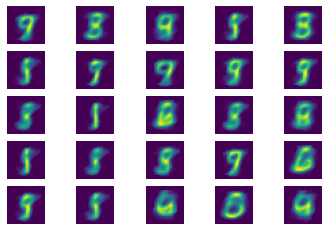

Historia del entrenamiento:


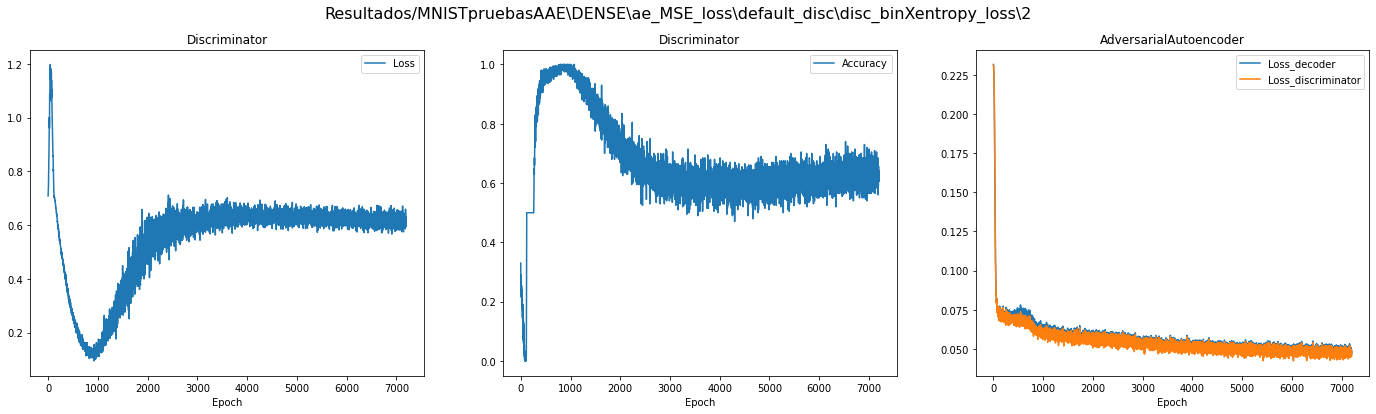

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


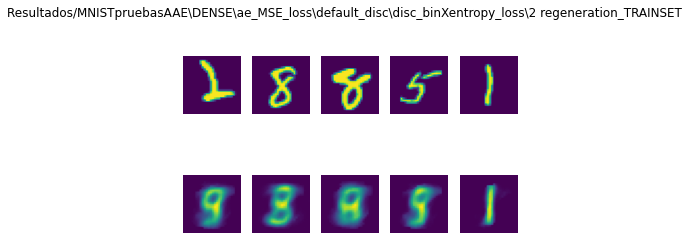

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


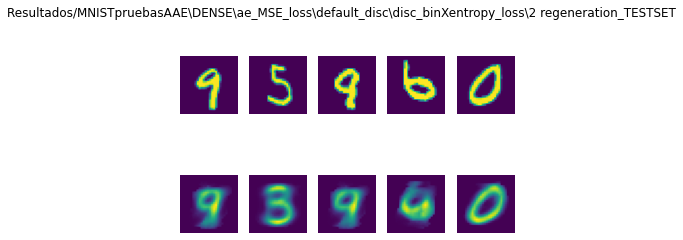

Representacion del espacio latente 2D:


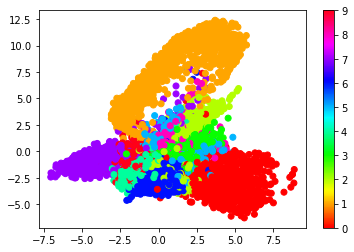

Layers for input 2 and output 1:
Layer 1: 2 neurons
Layer 2: 1 neurons
Layers for input 10 and output 1:
Layer 1: 5 neurons
Layer 2: 2 neurons
Layers for input 784 and output 2:
Layer 1: 107 neurons
Layer 2: 15 neurons
Layers for input 2 and output 784:
Layer 1: 15 neurons
Layer 2: 107 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 7.642602, acc = 50.00%) AAE: (mse = 0.073840, b_ce = 0.073914)
Epoch: 0 Step: 199 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.070734, b_ce = 0.070804)
Epoch: 0 Step: 299 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.066831, b_ce = 0.066898)
Epoch: 0 Step: 399 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.065045, b_ce = 0.065110)
Epoch: 0 Step: 499 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.062251, b_ce = 0.062314)
Epoch: 0 Step: 599 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.061112, b_ce = 0.061173)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 7.624619, acc = 50.00%) AAE: (mse = 0.063392, b_ce = 0.063455)
Epoch: 1 Step: 199 

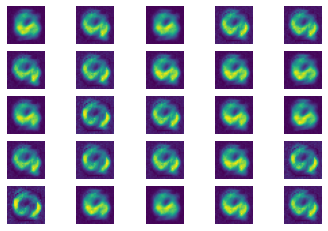

Historia del entrenamiento:


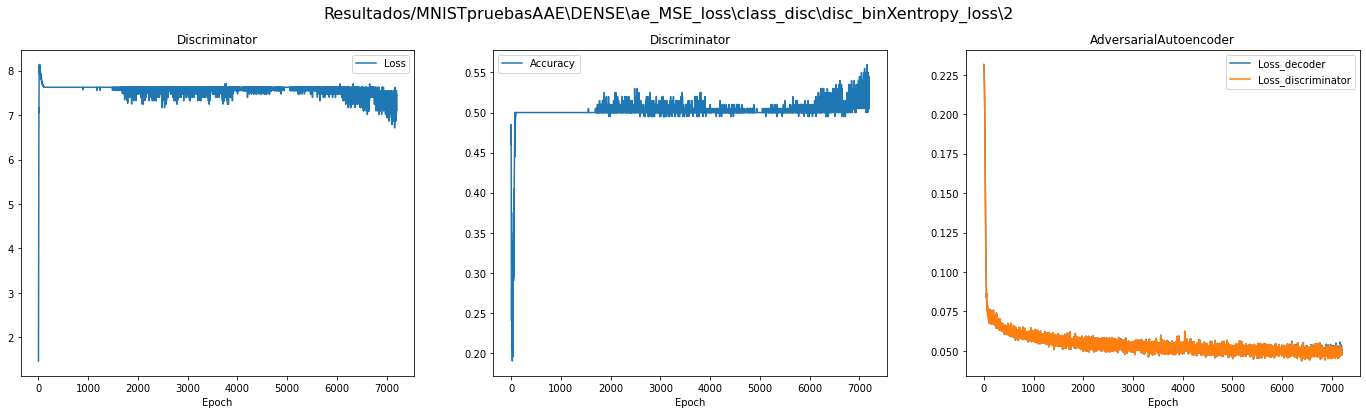

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


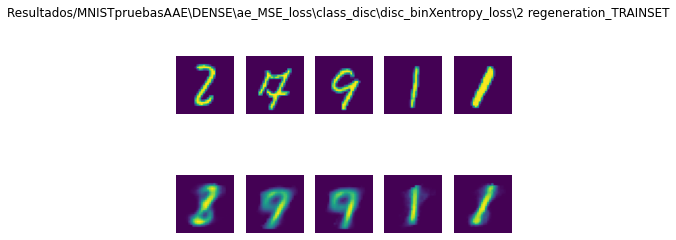

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


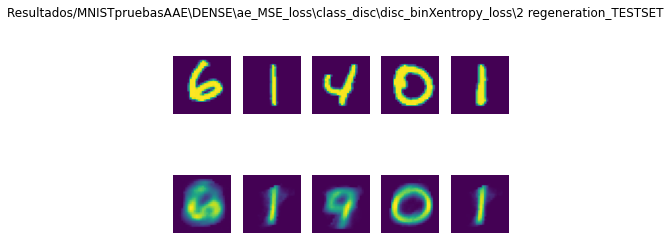

Representacion del espacio latente 2D:


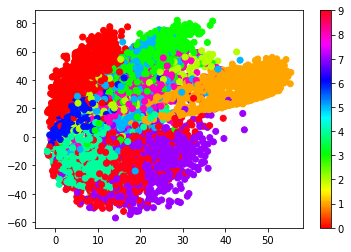

In [28]:
enc = (build_dense_encoder, "dense_enc")
dec = (build_dense_decoder,"dense_dec")
model_name = "DENSE"

mainLoop(enc=enc, dec=dec, model_name=model_name)


Layers for input 2 and output 1:
Layer 1: 2 neurons
Layer 2: 1 neurons
EPOCH 0


C:\Users\bitde\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch: 0 Step: 99 Disc: (loss = 0.495370, acc = 91.00%) AAE: (mse = 0.069982, b_ce = 0.069280)
Epoch: 0 Step: 199 Disc: (loss = 0.380273, acc = 99.00%) AAE: (mse = 0.065901, b_ce = 0.065137)
Epoch: 0 Step: 299 Disc: (loss = 0.375132, acc = 90.50%) AAE: (mse = 0.061056, b_ce = 0.060258)
Epoch: 0 Step: 399 Disc: (loss = 0.590688, acc = 79.00%) AAE: (mse = 0.062225, b_ce = 0.061562)
Epoch: 0 Step: 499 Disc: (loss = 0.585847, acc = 76.00%) AAE: (mse = 0.059286, b_ce = 0.058570)
Epoch: 0 Step: 599 Disc: (loss = 0.520064, acc = 73.50%) AAE: (mse = 0.058140, b_ce = 0.057327)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.467181, acc = 79.00%) AAE: (mse = 0.061037, b_ce = 0.060078)
Epoch: 1 Step: 199 Disc: (loss = 0.423784, acc = 82.50%) AAE: (mse = 0.062040, b_ce = 0.061055)
Epoch: 1 Step: 299 Disc: (loss = 0.427640, acc = 80.00%) AAE: (mse = 0.057549, b_ce = 0.056540)
Epoch: 1 Step: 399 Disc: (loss = 0.451865, acc = 79.00%) AAE: (mse = 0.057158, b_ce = 0.056107)
Epoch: 1 Step: 499 Disc: (loss = 0

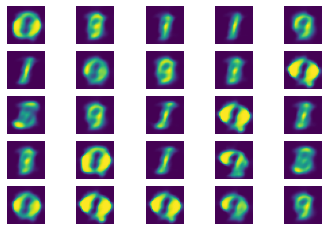

Historia del entrenamiento:


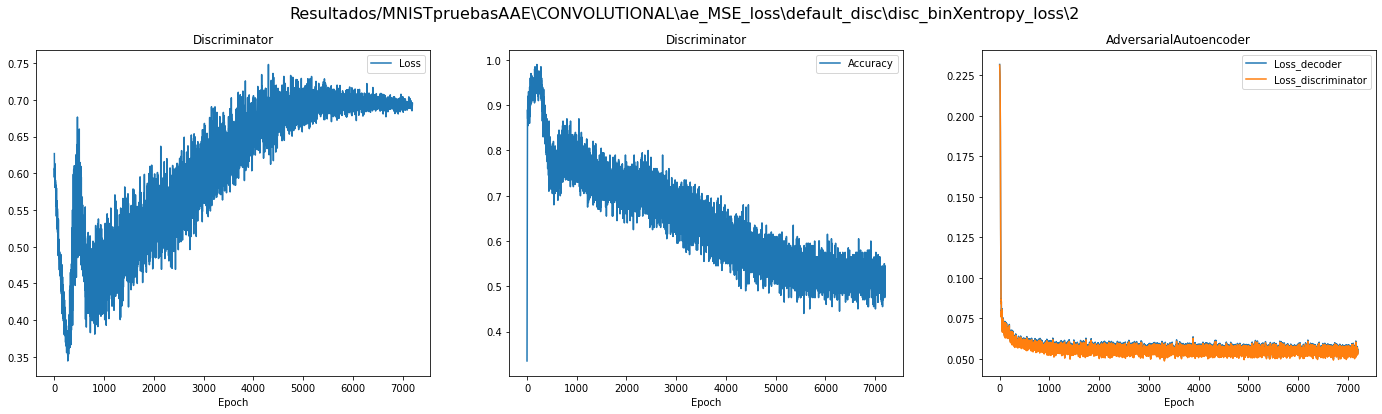

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


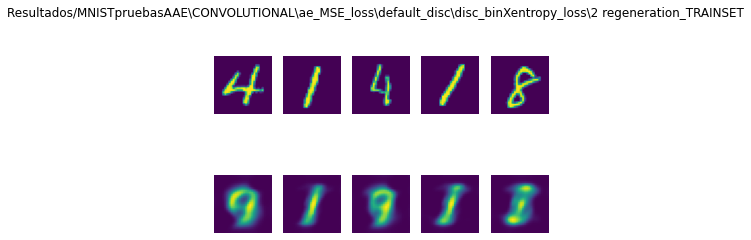

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


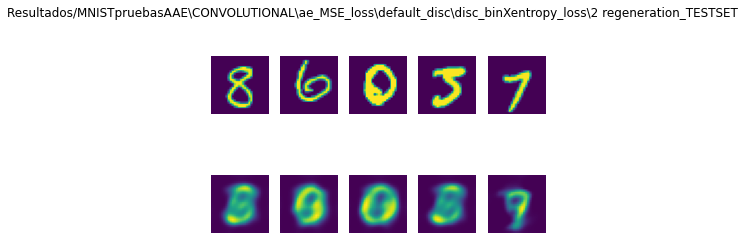

Representacion del espacio latente 2D:


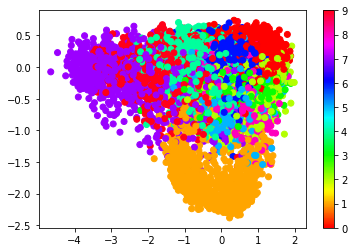

Layers for input 2 and output 1:
Layer 1: 2 neurons
Layer 2: 1 neurons
Layers for input 10 and output 1:
Layer 1: 5 neurons
Layer 2: 2 neurons
EPOCH 0
Epoch: 0 Step: 99 Disc: (loss = 0.752993, acc = 50.00%) AAE: (mse = 0.071367, b_ce = 0.069701)
Epoch: 0 Step: 199 Disc: (loss = 0.398644, acc = 100.00%) AAE: (mse = 0.065965, b_ce = 0.064909)
Epoch: 0 Step: 299 Disc: (loss = 0.153883, acc = 100.00%) AAE: (mse = 0.065534, b_ce = 0.063945)
Epoch: 0 Step: 399 Disc: (loss = 0.154932, acc = 98.50%) AAE: (mse = 0.070033, b_ce = 0.066506)
Epoch: 0 Step: 499 Disc: (loss = 0.521015, acc = 82.50%) AAE: (mse = 0.063666, b_ce = 0.062620)
Epoch: 0 Step: 599 Disc: (loss = 0.474201, acc = 78.50%) AAE: (mse = 0.062225, b_ce = 0.061246)
EPOCH 1
Epoch: 1 Step: 99 Disc: (loss = 0.584665, acc = 69.50%) AAE: (mse = 0.063785, b_ce = 0.062877)
Epoch: 1 Step: 199 Disc: (loss = 0.770849, acc = 58.00%) AAE: (mse = 0.065202, b_ce = 0.064449)
Epoch: 1 Step: 299 Disc: (loss = 0.837438, acc = 41.00%) AAE: (mse = 0.06

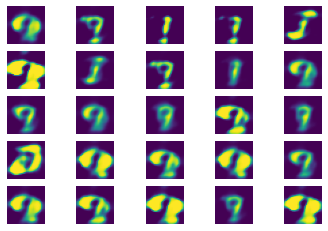

Historia del entrenamiento:


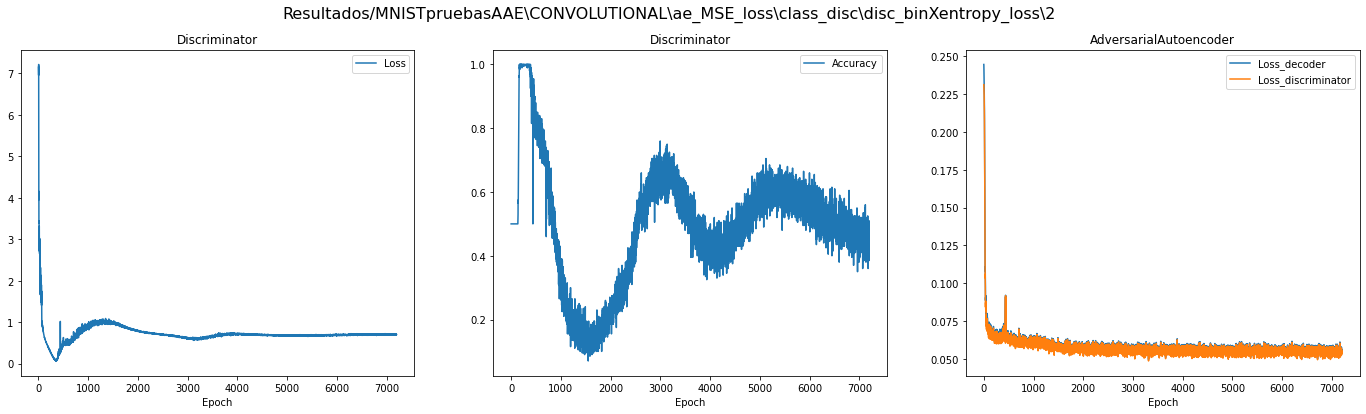

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


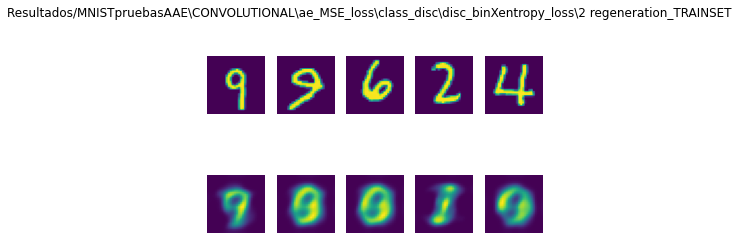

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


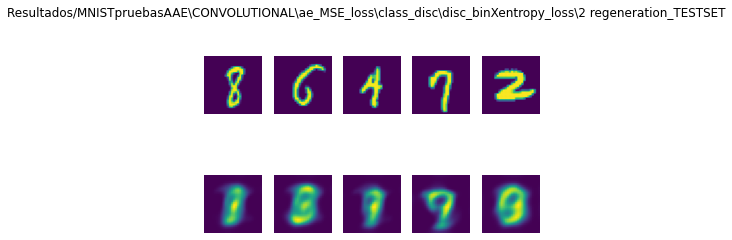

Representacion del espacio latente 2D:


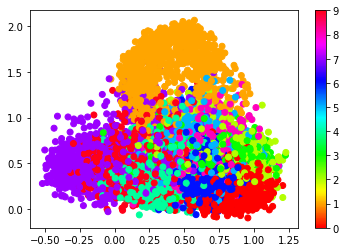

In [29]:
enc = (build_conv_encoder, "conv_enc")
dec = (build_conv_decoder,"conv_dec")
model_name = "CONVOLUTIONAL"

mainLoop(enc=enc, dec=dec, model_name=model_name)

In [30]:
# Movnet necesita 3 canales, MNIST tiene solo 1
#enc = (build_transf_encoder, "transf_enc")
#dec = (build_conv_decoder,"conv_dec")
#model_name = "TRANSF_MOVNET"

#mainLoop(enc=enc, dec=dec, model_name=model_name)